## Functions

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

### Combine Data

In [ ]:
def combine_data(dataframes_list: list[pd.DataFrame]) -> pd.DataFrame:
    
    
    # Required columns
    required_columns = ['nodeUserID', 'nodeTime', 'videoID', 'platform']
    
    # Process each dataframe to keep only required columns
    processed_dfs = []
    for i, df in enumerate(dataframes_list):
        # Check if all required columns exist
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"DataFrame at index {i} is missing required columns: {missing_cols}")
        
        # Select only the required columns
        processed_df = df[required_columns].copy()
        processed_dfs.append(processed_df)
    
    # Concatenate all processed dataframes
    combined_df = pd.concat(processed_dfs, ignore_index=True)  

    # Setting datatypes to the columns
    combined_df['nodeUserID'] = combined_df['nodeUserID'].astype(str)
    combined_df['videoID'] = combined_df['videoID'].astype(str)
    combined_df['platform'] = combined_df['platform'].astype(str)
    combined_df['nodeTime'] = pd.to_datetime(combined_df['nodeTime'])
    
    return combined_df

### Build Network

In [4]:
def build_network(df: pd.DataFrame) -> nx.Graph:
    
    # Initialize a new graph
    G = nx.Graph()
    
    # Add nodes for each unique user with platform attribute
    users = df[['nodeUserID', 'platform']].drop_duplicates()
    for _, row in users.iterrows():
        user_id = f"user_{row['nodeUserID']}"
        G.add_node(user_id, bipartite=0, platform=row['platform'], node_type='user')
    
    # Add nodes for each unique video
    videos = df['videoID'].unique()
    for video_id in videos:
        video_node = f"video_{video_id}"
        G.add_node(video_node, bipartite=1, platform='youtube', node_type='video')
    
    # Add edges between users and videos
    for _, row in df.iterrows():
        user_node = f"user_{row['nodeUserID']}"
        video_node = f"video_{row['videoID']}"
        G.add_edge(user_node, video_node)
    
    return G

### Get user interactions

In [ ]:
def get_user_interactions(df: pd.DataFrame, start_seconds_threshold: int = 0, end_seconds_threshold: int = 52) -> pd.DataFrame:

    # Ensure 'nodeUserID' is string type
    df['nodeUserID'] = df['nodeUserID'].astype(str)

    # Ensure 'nodeTime' is datetime type
    df['nodeTime'] = pd.to_datetime(df['nodeTime'], errors='coerce')
    
    # Self-Merge on 'videoID'
    # We only select relevant columns to save memory during the merge
    subset = df[['nodeUserID', 'nodeTime', 'videoID']]
    merged = pd.merge(subset, subset, on='videoID', suffixes=('1', '2'))

    # Remove self-loops and duplicate pairs (A-B is same as B-A)
    # We enforce UserID1 < UserID2 to ensure unique pairs
    merged = merged[merged['nodeUserID1'] < merged['nodeUserID2']]

    # Calculate absolute difference between timestamps
    time_diff = (merged['nodeTime1'] - merged['nodeTime2']).abs()
    
    # Converting difference to seconds
    seconds_diff = time_diff.dt.total_seconds()
    
    # Filter based on difference
    valid_interactions = merged[seconds_diff.between(start_seconds_threshold, end_seconds_threshold, inclusive='left')]

    # Aggregation: Count distinct videoIDs per user pair
    result = (
        valid_interactions
        .groupby(['nodeUserID1', 'nodeUserID2'])['videoID']
        .nunique() # Count distinct videos
        .reset_index()
    )

    # Rename column to match requirements
    result.rename(columns={'videoID': 'sharedVideos'}, inplace=True)

    return result

### Add user interactions

In [47]:
def add_user_interaction_edges(G: nx.Graph, df_interactions: pd.DataFrame) -> nx.Graph:
    # Create a list of edges in the format: (u, v, attributes_dictionary)
    # We use itertuples() because it is much faster than iterrows()
    edges_to_add = [
        (
            "user_" + str(row.nodeUserID1), 
            "user_" + str(row.nodeUserID2), 
            {'sharedVideos': row.sharedVideos}
        )
        for row in df_interactions.itertuples(index=False)
    ]

    # Add these edges to the graph in one batch
    # If the edge already exists, this will update/overwrite the attribute
    G.add_edges_from(edges_to_add)

    return G

### Get network metrics

In [93]:
def get_network_metrics(G):
    # Calculate the metrics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    avg_clustering = nx.average_clustering(G)
    
    # Communities
    communities = nx.community.louvain_communities(G)
    num_communities = len(communities)
    modularity_score = nx.community.modularity(G, communities)

    # Handle Components
    num_components = nx.number_connected_components(G)
    largest_cc = len(max(nx.connected_components(G), key=len))
    
    # Create the Data Dictionary
    stats = {
        'nodes': num_nodes,
        'edges': num_edges,
        'density': round(density, 5),
        'avg clustering': round(avg_clustering, 4),
        'connected components': num_components,
        'largest component size': largest_cc,
        'isolates': nx.number_of_isolates(G), # Nodes with 0 connections
        'communities': num_communities,
        'modularity': modularity_score
    }

    # Convert to DataFrame
    df_stats = pd.DataFrame(stats, index=[0])
    
    return df_stats

### Get shared video counts

In [86]:
def get_shared_video_counts(df: pd.DataFrame) -> pd.DataFrame:
    # Select only necessary 
    subset = df[['nodeUserID', 'videoID', 'platform']].drop_duplicates()

    # Connect every user to every other user who posted the same video
    merged = pd.merge(subset, subset, on='videoID', suffixes=('1', '2'))

    # Filter Self-Loops and Duplicates
    merged = merged[merged['nodeUserID1'] < merged['nodeUserID2']]

    # Count how many videoIDs exist for each pair
    result = (
        merged
        .groupby(['nodeUserID1', 'platform1', 'nodeUserID2', 'platform2'])
        .size()
        .reset_index(name='sharedVideos')
    )
    
    return result

### Get users network

In [198]:
def get_users_network(df: pd.DataFrame, min_shared_videos: int = 1) -> nx.Graph:
    
    
    # Filter by Threshold
    filtered_df = df[df['sharedVideos'] >= min_shared_videos].copy()
    
    # Create the Graph and Edges
    G = nx.from_pandas_edgelist(
        filtered_df,
        source='nodeUserID1',
        target='nodeUserID2',
        edge_attr=['sharedVideos'] 
    )
    
    # Explicitly set the 'weight' attribute
    for u, v, data in G.edges(data=True):
        data['weight'] = data['sharedVideos']

    # Assign Node Attributes (Platform)
    # Get pairs from column 1
    sources = filtered_df[['nodeUserID1', 'platform1']].rename(
        columns={'nodeUserID1': 'node', 'platform1': 'platform'}
    )
    # Get pairs from column 2
    targets = filtered_df[['nodeUserID2', 'platform2']].rename(
        columns={'nodeUserID2': 'node', 'platform2': 'platform'}
    )
    
    # Combine them and drop duplicates
    all_nodes_attr = pd.concat([sources, targets]).drop_duplicates(subset=['node'])
    platform_dict = all_nodes_attr.set_index('node')['platform'].to_dict()
    
    # Apply attributes to the graph
    nx.set_node_attributes(G, platform_dict, name='platform')
    
    return G

### Assign roles to users

In [150]:
def assign_roles_to_users(G, influencer_percentile=0.95, distributor_percentile=0.80):
    
    centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    scores = pd.Series(centrality)
    
    # The 'Influencer' cut-off
    influencer_cutoff = scores.quantile(influencer_percentile)
    
    # The 'Distributor' cut-off
    distributor_cutoff = scores.quantile(distributor_percentile)
    
    
    # Create Dictionaries for Attributes
    roles = {}
    
    for node, score in scores.items():
        if score >= influencer_cutoff:
            roles[node] = 'Influencer'
        elif score >= distributor_cutoff:
            roles[node] = 'Distributor'
        else:
            roles[node] = 'Consumer'
    
    # Inject Attributes back into the Graph
    nx.set_node_attributes(G, centrality, 'eigenvector_centrality')
    nx.set_node_attributes(G, roles, 'role')
    
    return G

### Plot role distribution

In [151]:
def plot_role_distribution(G):
    # Extract the scores and roles from the graph
    data = []
    for n, d in G.nodes(data=True):
        # We need the score. If it's not there, we calculate it on the fly.
        score = d.get('eigenvector_centrality', 0)
        role = d.get('role', 'Consumer')
        data.append({'score': score, 'role': role})
    
    df = pd.DataFrame(data)
    
    influencers = df[df['role'] == 'Influencer']['score']
    distributors = df[df['role'] == 'Distributor']['score']
    consumers = df[df['role'] == 'Consumer']['score']

    # Plotting
    plt.figure(figsize=(8, 5))
    
    plt.hist([consumers, distributors, influencers], 
             bins=50, 
             stacked=True,
             color=['#6495ED', '#FFA500', '#DC143C'],
             label=['Consumer', 'Distributor', 'Influencer'],
             edgecolor='black',
             linewidth=0.5,
             alpha=0.8)

    plt.yscale('log')
    plt.title('User Distribution by Assigned Role', fontsize=16)
    plt.xlabel('Eigenvector Centrality Score (Influence)', fontsize=12)
    plt.ylabel('Number of Users (Log Scale)', fontsize=12)
    
    # Add a legend
    plt.legend(title="Role")
    plt.grid(axis='y', alpha=0.3, which='major')
    
    plt.tight_layout()
    plt.show()

## Exploration

### Dataset description

First we need to load the data and explore the structure of the network.

In [192]:
# Loading data from different platforms
dfFacebook = pd.read_csv('data/facebook_cross_platform.csv')
dfReddit = pd.read_csv('data/reddit_cross_platform.csv')
dfTwitter = pd.read_csv("data/twitter_cross_platform.csv")
dfYoutube = pd.read_csv("data/youtube_cross_platform.csv")

# Combining Data
dfCombined = combine_data(dataframes_list = [dfFacebook, dfReddit, dfTwitter])
dfCombined.head()

,nodeUserID,nodeTime,videoID,platform
0,548542,2018-04-01 10:22:08,VLMOHhKkrX8,facebook
1,5465518,2018-04-05 00:04:00,OBkn78q_t_Q,facebook
2,6119363,2018-04-05 07:12:02,3wj4ncIEDxw,facebook
3,8621215,2018-04-05 18:22:26,3wj4ncIEDxw,facebook
4,12041680,2018-04-08 15:08:50,mvD7qhDwljs,facebook


We are gonna validate that we do not have duplicates of user across platforms that could forces us to transform the IDs.

In [193]:
# Calculate how many unique platforms each user has
platform_counts = dfCombined.groupby('nodeUserID')['platform'].transform('nunique')

# Filter the dataframe to keep only users with > 1 platform
violators = dfCombined[platform_counts > 1]

if not violators.empty:
    print("Found users across multiple platforms:")
    print(violators.sort_values('nodeUserID'))
else:
    print("No users found across multiple platforms.")

No users found across multiple platforms.


We validated that user IDs are unique for each platform. Now let's get some statistics about the combined dataset.

In [194]:
# Getting some information of the datasets
dfDescribe =dfCombined.describe(include='all')
dfDescribe = pd.concat([dfDescribe,
    pd.DataFrame({
        'type': dfCombined.dtypes,
        'missing': dfCombined.isnull().sum(),
        'missing %': (dfCombined.isnull().mean() * 100).round(2)
    }).T
])
dfDescribe

,nodeUserID,nodeTime,videoID,platform
count,16565,16565,16565,16565
unique,5897,16279,667,3
top,a0fYqjn3qCvgH6MYNqZRew,2018-04-21 17:27:52,CCmN6X_7kn0,twitter
freq,2470,6,2342,14942
type,object,object,object,object
missing,0,0,0,0
missing %,0.0,0.0,0.0,0.0


From previous tables we validated that datasets were well combined. Also, we don't have any null values which is good for our analysis. Finally, it seems that we got more instances from the twitter dataset.

Now we are gonna do the same process with the video dataset

In [195]:
dfYoutube = pd.read_csv("data/youtube_cross_platform.csv")
dfYoutube.head()

,videoID,video_channel,nodeTime
0,Zd6bAEMu5Yk,twotwo30Productions,2006-09-22 21:10:44
1,VU3RHNLzh-I,معاٌ لدعم الدفاع المدني السوري,2014-06-19 10:29:28
2,tdFHNE8WxOA,ZFront Kharkov UA,2014-07-08 14:28:21
3,12irnW4FNFY,ODN,2014-07-12 10:25:05
4,6h0VDhENotI,The Syria Campaign,2014-08-27 12:33:36


In [196]:
# Getting some information of the datasets
dfDescribeVideos =dfYoutube.describe(include='all')
dfDescribeVideos = pd.concat([dfDescribeVideos,
    pd.DataFrame({
        'type': dfYoutube.dtypes,
        'missing': dfYoutube.isnull().sum(),
        'missing %': (dfYoutube.isnull().mean() * 100).round(2)
    }).T
])
dfDescribeVideos

,videoID,video_channel,nodeTime
count,667,667,667
unique,667,283,667
top,Zd6bAEMu5Yk,vanessa beeley,2006-09-22 21:10:44
freq,1,60,1
type,object,object,object
missing,0,0,0
missing %,0.0,0.0,0.0


We validated that our videos dataset looks very well. It does not have any null values and any duplicates. We can use these datasets without any transformations.

### Network Visualization

Now let's build the network using the different datasets and get some basic metrics that could help us understand the structure of the network.

In [ ]:
# Getting the connections between users who posted same video
dfUserConnections = get_user_interactions(dfCombined, start_seconds_threshold = 0, end_seconds_threshold = 52)

# Building the network with connections between users and videos
G_original = build_network(dfCombined)

# Adding connections between users
G_original = add_user_interaction_edges(G_original, dfUserConnections)

# Showing metrics from our network
dfMetrics = get_network_metrics(G_original)
dfMetrics


,nodes,edges,density,avg clustering,connected components,largest component size,isolates,communities,modularity
0,6564,10262,0.00048,0.0783,100,6235,0,136,0.708567


From the previous metrics we can see that we have a very sparse network, this is expected as the network has many nodes. Also, we can see that the network is not connected, there are 100 components. The largest component has 6235 nodes, we can use this component for our analysis. 

Also it's interesting to see that we have a high value of clustering coefficient. Also the modularity is relative high, this could give us a hint of the community structure of the network.

In [60]:
# Getting just the largest component
G_transformed = G_original.subgraph(max(nx.connected_components(G_original), key=len))

# Writing the network to plot it in Gephi
nx.write_gexf(G_transformed, "transformed_network.gexf")

# Showing some metrics
print("Number of nodes:", G_transformed.number_of_nodes())
print("Number of edges:", G_transformed.number_of_edges())
print("Density:", nx.density(G_transformed))
print("Average degree:", np.mean(list(dict(G_transformed.degree()).values())))

Number of nodes: 6235
Number of edges: 10015
Density: 0.000515320825161652
Average degree: 3.2125100240577384


<center>
<h3> Connected Network of Users and Videos </h3>
<img src="images/original_network.png" alt="Connected Network of Users and Videos with Gephi" width="600" height="600">
</center>

From the previous network we can see that there are hubs that concentrate many nodes, presumably because they are viral videos promoted by users with a coordinated strategy. From these hubs we see that there are two types of users connected:
- Users that are only connected to one video node. We think that they are users that engaged organically with the video.
- Users that are connected to many video nodes. They are located in the center of the network. We think that they could have a coordinated strategy in order to promote some of the videos.

### Getting users network

Our hypothesis is that users with coordinated behavior are more likely to share the same videos. If we connect users based on the videos that they post and this connection is weighted by the number of videos they have in common, we expect to see a strong community structure in coordinated users.

In [90]:
dfUserCounts = get_shared_video_counts(dfCombined)
dfUserCounts.head()

,nodeUserID1,platform1,nodeUserID2,platform2,sharedVideos
0,---0qUylIJzj8kr2P8ugDg,twitter,10118082,facebook,1
1,---0qUylIJzj8kr2P8ugDg,twitter,EvttAa1o56OZCUngk0flcA,twitter,1
2,---0qUylIJzj8kr2P8ugDg,twitter,NUkHCk9oOonq8cuJKbwzFQ,twitter,1
3,---0qUylIJzj8kr2P8ugDg,twitter,ev2obIiRHGJBIyqvPw_SHg,twitter,1
4,---0qUylIJzj8kr2P8ugDg,twitter,fFH3InGzF_Xg2rUtFLg4Ag,twitter,1


In [199]:
# Building the network of users
G_users_network = get_users_network(dfUserCounts, min_shared_videos=3)

# Writing the network to plot it in Gephi
nx.write_gexf(G_users_network, "users_network.gexf")

# Showing metrics from our network
dfMetrics_users = get_network_metrics(G_users_network)
dfMetrics_users

,nodes,edges,density,avg clustering,connected components,largest component size,isolates,communities,modularity
0,402,1597,0.01981,0.5407,10,382,0,15,0.409816


<center>
<h3> Connected network of users with at least 3 shared videos </h3>
<img src="images/users_network.png" alt="Gephi Network" width="600" height="600">
</center>

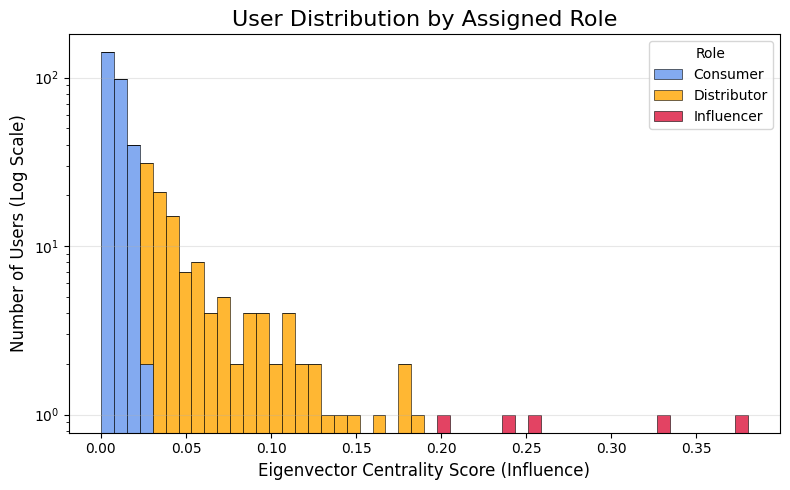

In [200]:
# Assign roles to users based on eigenvector centrality (influence)
G_roles_network = assign_roles_to_users(G_users_network, influencer_percentile=0.99, distributor_percentile=0.70)

# Writing the network to plot it in Gephi
nx.write_gexf(G_roles_network, "roles_network.gexf")

# Plot role distribution
plot_role_distribution(G_roles_network)

<center>
<h3> Connected network of users with assigned roles </h3>
<img src="images/roles_network.png" alt="Gephi Network" width="600" height="600">
</center>

In [212]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import networkx as nx

def plot_top20_role_scatter(df: pd.DataFrame, dfVideo: pd.DataFrame, G: nx.Graph):
    """
    Plots a scatter chart of User Activity for the TOP 20 most active videos.
    Filters out users who do not have an assigned role in the network.
    """
    
    # 1. Get Network Roles
    # This dictionary contains only the users who are part of the graph
    network_roles = nx.get_node_attributes(G, 'role')
    
    # 2. Filter for Top 20 Videos
    top_20_ids = df['videoID'].value_counts().nlargest(50).index.tolist()
    
    # 3. Apply DOUBLE Filter:
    # Condition A: Must be in the Top 20 Videos
    # Condition B: Must be in the Network (have a role)
    df_filtered = df[
        (df['videoID'].isin(top_20_ids))
    ].copy()
    
    if df_filtered.empty:
        print("⚠️ No data found. Either no top videos or no users with roles match the dataframe.")
        return

    # 4. Prepare Data
    df_filtered['nodeTime'] = pd.to_datetime(df_filtered['nodeTime'])
    
    # 5. Define Color Mapping (No Green anymore)
    def get_color(user_id):
        # We don't need to check "if not in network" because we already filtered them out!
        try:
            role = network_roles[user_id]
        except KeyError:
            return 'green' # No Role
        if role == 'Influencer': return 'red'
        elif role == 'Distributor': return 'orange'
        elif role == 'Consumer': return 'blue'
        else: return 'green' # No Role

    # Get a dict of video names
    video_names = dfVideo.set_index('videoID')['video_channel'].to_dict()

    # Creating video name column
    df_filtered['video_name'] = df_filtered['videoID'].map(video_names)

    plot_colors = df_filtered['nodeUserID'].apply(get_color)
    
    # 6. Create the Plot
    plt.figure(figsize=(15, 10))
    
    # Sort Y-axis by popularity
    df_filtered['videoID'] = pd.Categorical(df_filtered['videoID'], categories=top_20_ids, ordered=True)
    
    plt.scatter(df_filtered['nodeTime'], df_filtered['video_name'], c=plot_colors, s=30, alpha=0.7, edgecolors='none')
    
    # 7. Legend (Removed 'No Role')
    legend_handles = [
        mpatches.Patch(color='red', label='Commander (Master)'),
        mpatches.Patch(color='orange', label='Distributor (Lieutenant)'),
        mpatches.Patch(color='blue', label='Consumer (Follower)')
    ]
    
    plt.legend(handles=legend_handles, loc='upper right', title="User Role", fontsize=11)
    plt.title('Timeline of Coordinated Activity (Top 20 Videos)', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Video ID (Ranked by Popularity)', fontsize=12)
    
    plt.gcf().autofmt_xdate()
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

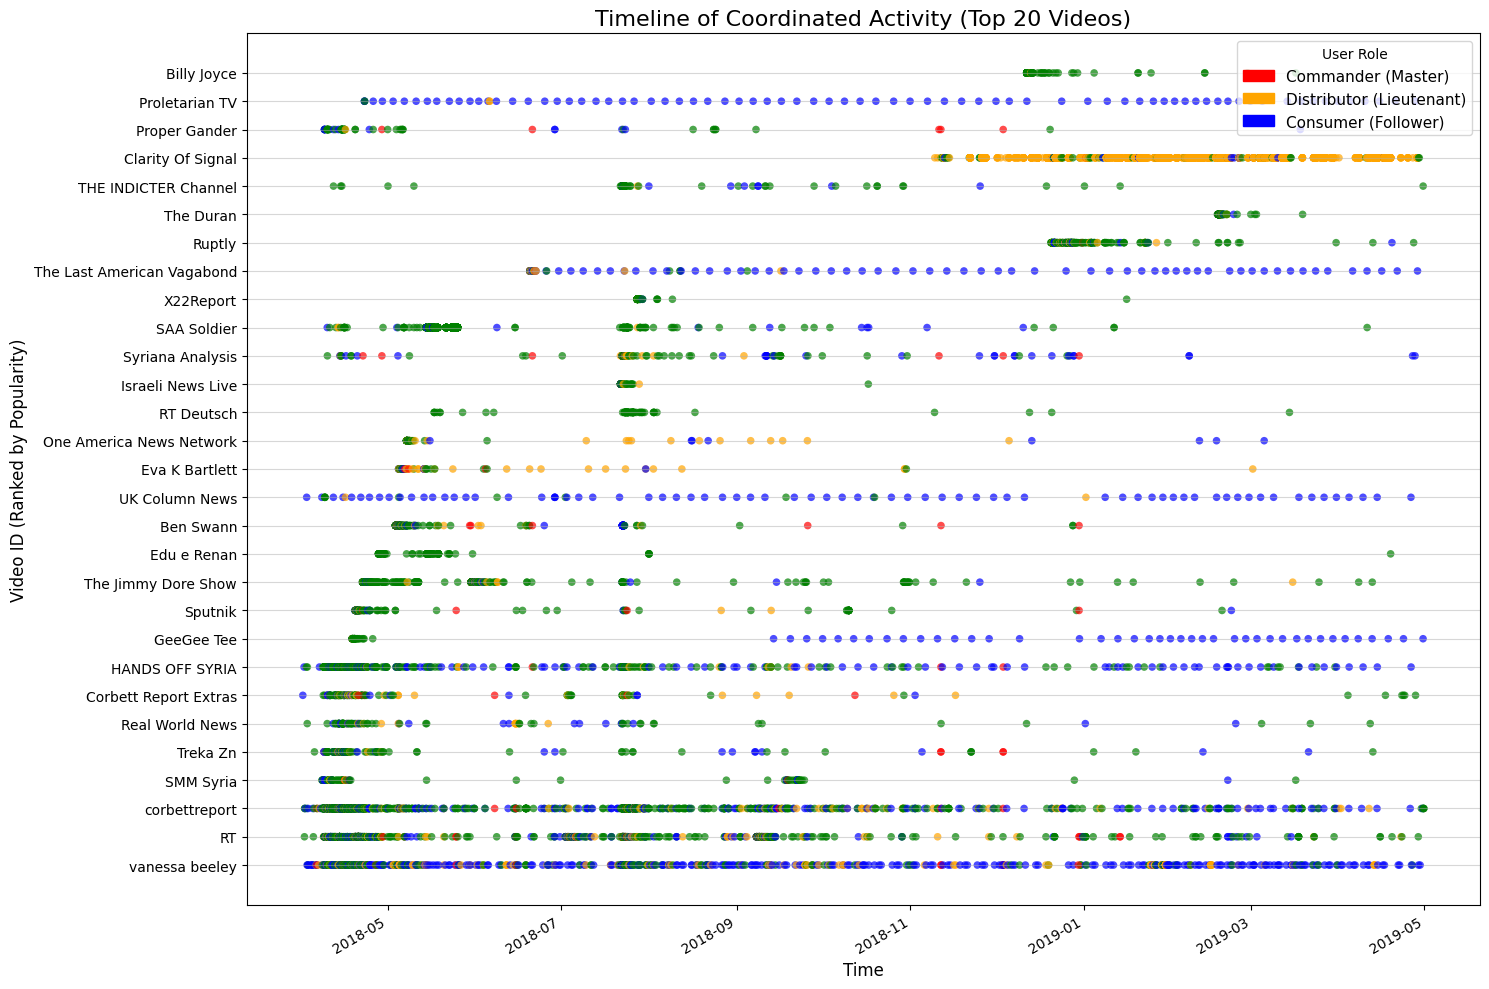

In [214]:

plot_top20_role_scatter(dfCombined, dfYoutube, G_roles_network)

## Baseline Metrics

## Experiments

### Method 1

For the method 1, we want to remove the current relation between users and the videos that they post, but we are not going to change the frequency of the videos that were posted. We can do this by shuffling the videoID column from our dataset.

In [ ]:
# Shuffling the video column
col_to_shuffle = 'videoID'
dfCombinedM1 = dfCombined.copy()
dfCombinedM1[col_to_shuffle] = np.random.permutation(dfCombinedM1[col_to_shuffle].values)

,nodeUserID,nodeTime,videoID,platform
0,548542,2018-04-01 10:22:08,X27B0yuazGo,facebook
1,5465518,2018-04-05 00:04:00,ooi1KktDVcU,facebook
2,6119363,2018-04-05 07:12:02,CYflh9ltqDY,facebook
3,8621215,2018-04-05 18:22:26,DPgOnD0n9uw,facebook
4,12041680,2018-04-08 15:08:50,3vNwe7yKbwo,facebook


Now we can create the network with this transformation

In [ ]:
# Getting the connections between users who posted same video
dfUserConnectionsM1 = get_user_interactions(dfCombinedM1, start_seconds_threshold = 0, end_seconds_threshold = 52)

# Building the network with connections between users and videos
G_originalM1 = build_network(dfCombinedM1)

# Adding connections between users
G_originalM1 = add_user_interaction_edges(G_originalM1, dfUserConnectionsM1)

# Getting metrics from our network
dfMetricsM1 = get_network_metrics(G_originalM1)

# Concatening with the baseline metrics
dfMetricsM1 = pd.concat([dfMetrics, dfMetricsM1], ignore_index=True)
dfMetricsM1['Model'] = ['Baseline', 'Method1']
cols = ['Model'] + [col for col in dfMetricsM1.columns if col != 'Model']
dfMetricsM1 = dfMetricsM1[cols]
dfMetricsM1

,Model,nodes,edges,density,avg clustering,connected components,largest component size,isolates,communities,modularity
0,Baseline,6564,10262,0.00048,0.0783,100,6235,0,136,0.708567
1,Method1,6564,12568,0.00058,0.0085,42,6472,0,78,0.519652


By comparing this basic metrics we can quickly notice that average clustering, communities and modularity were reduced. This is a clear sign that by shuffling the user and video relation we are destroying some of the communities as well. In an organic network, these communities should not exist or at least the change should be minimal.

Now, we are going to focus again in the largest component of the network. Then we are going to plot so we can get some quick insights.

In [72]:
# Getting just the largest component
G_transformedM1 = G_originalM1.subgraph(max(nx.connected_components(G_originalM1), key=len))

# Writing the network to plot it in Gephi
nx.write_gexf(G_transformedM1, "transformed_networkM1.gexf")

# Showing some metrics
print("Number of nodes:", G_transformedM1.number_of_nodes())
print("Number of edges:", G_transformedM1.number_of_edges())
print("Density:", nx.density(G_transformedM1))
print("Average degree:", np.mean(list(dict(G_transformedM1.degree()).values())))

Number of nodes: 6472
Number of edges: 12517
Density: 0.0005977510387219656
Average degree: 3.8680469715698393


<center>
<h3> Connected Network of Users and Videos with Method 1 </h3>
<img src="images/m1_network.png" alt="Connected Network of Users and Videos with Gephi" width="600" height="600">
</center>

We can see from the previous plot that hubs are less evident compared to the baseline network. Also there are a group of twitter users that are connected to many videos, this is the reason now this network has many twitter nodes in the center.

It is evident that the network structure has changed. Specially the video nodes seem to have an uniformed distribution of degrees.

Using Gephi, we noticed that connections between users were reduced. Thas is sensible since users that had a connection because they shared the same video now they are not connected because of the shuffling.

### Method 2

### Method 3

## Comparison